In [1]:
from fastai.vision.all import *
import re
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))
from enveco.data.image import *
from enveco.metrics import *
from enveco.interpretation import *

import rasterio as rio

In [2]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [3]:
def plot_gradcam(learner, inp, ax, target_class=None, target_layer=None, im_cls=TensorImage, **plot_kws):
    "If target class is not specified, calculate in respect to prediction"
    if target_class is None:
        with torch.no_grad(): target_class = learner.model.eval()(inp[None].cuda()).argmax().item()
            
    if target_layer is None:
        with HookBwd(learner.model[0]) as hookg:
            with Hook(learner.model[0]) as hook:
                outp = learner.model.eval()(inp[None].cuda())
                act = hook.stored
            outp[0, target_class].backward()
            grad = hookg.stored
    else:
        with HookBwd(learner.model[0][target_layer]) as hookg:
            with Hook(learner.model[0][target_layer]) as hook:
                outp = learner.model.eval()(inp[None].cuda())
                act = hook.stored
            outp[0, target_class].backward()
            grad = hookg.stored        

    w = grad[0].mean(dim=[1,2], keepdim=True)
    cam_map = (w * act[0]).sum(0)
    im_cls(learner.dls.train.decode((inp,))[0][0]).show(ctx=ax, **plot_kws)
    
    ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,inp.shape[-1],inp.shape[-1],0),
              interpolation='bilinear', cmap='magma')
    return ax

# Read data, preprocess and get mean/std

In [4]:
data_path = Path('../../../andras/ml/AV_leafon')

In [5]:
train_df = pd.read_csv(data_path/'AV.leaf.on.train.csv')
train_df = train_df.rename(columns = lambda x: re.sub('[\.]+', '_', x))

valid_df = pd.read_csv(data_path/'AV.leaf.on.val.csv')
valid_df = valid_df.rename(columns = lambda x: re.sub('[\.]+', '_', x))

test_df = pd.read_csv(data_path/'AV.leaf.on.test.csv')
test_df = test_df.rename(columns = lambda x: re.sub('[\.]+', '_', x))

In [6]:
outpath = Path('../../data')
if not os.path.exists(outpath): os.makedirs(outpath)


In [7]:
rawims = []
for row in train_df.itertuples():
    with rio.open(data_path/f'AV_tif/{row.sampleplotid}.tif') as src:
        vals = src.read().astype(np.float32)
    rawims.append(vals / 255.)

In [8]:
rawimsarr = np.array(rawims)
rawimsarr.shape

(1044, 3, 61, 61)

In [9]:
rawims = None

In [10]:
means = np.nanmean(rawimsarr, axis=(0,2,3))
stds = np.nanstd(rawimsarr, axis=(0,2,3))
stats = np.array((means, stds))


In [11]:
def tree_pcts(row):
    pcts = [np.round(row.v_ma/row.v,2), np.round(row.v_ku/row.v,2), np.round(row.v_lp/row.v,2)]
    return pcts

In [12]:
def species_in_plot(row):
    retspecies = ''
    if row.rel_v_ma > 0.0: retspecies = retspecies + 'Pine;'
    if row.rel_v_ku > 0.0: retspecies = retspecies + 'Spruce;'
    if row.rel_v_lp > 0.0: retspecies = retspecies + 'Broadleaf;'
    return retspecies[:-1]

In [13]:
def dist_classes(sp_pct):
    labels = [f'q{i}' for i in range(0, 10)]
    return labels[int(np.ceil(sp_pct * 10))-1]

In [14]:
def maj_species(row):
    vals = [row.rel_v_ma, row.rel_v_ku, row.rel_v_lp]
    species = ['Pine', 'Spruce', 'Broadleaved']
    return species[vals.index(max(vals))]

In [15]:
def species_present(sp_pct):
    if sp_pct > 0.05: return 1
    return 0

In [16]:
train_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = train_df.apply(lambda row: tree_pcts(row), axis=1, result_type='expand')
valid_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = valid_df.apply(lambda row: tree_pcts(row), axis=1, result_type='expand')
test_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = test_df.apply(lambda row: tree_pcts(row), axis=1, result_type='expand')

In [17]:
train_df['species_in_plot'] = train_df.apply(lambda row: species_in_plot(row), axis=1)
test_df['species_in_plot'] = test_df.apply(lambda row: species_in_plot(row), axis=1)
valid_df['species_in_plot'] = valid_df.apply(lambda row: species_in_plot(row), axis=1)

In [18]:
train_df['pine_present'] = train_df.apply(lambda row: species_present(row.rel_v_ma), axis=1)
valid_df['pine_present'] = valid_df.apply(lambda row: species_present(row.rel_v_ma), axis=1)
test_df['pine_present'] = test_df.apply(lambda row: species_present(row.rel_v_ma), axis=1)


In [19]:
train_df['spruce_present'] = train_df.apply(lambda row: species_present(row.rel_v_ku), axis=1)
valid_df['spruce_present'] = valid_df.apply(lambda row: species_present(row.rel_v_ku), axis=1)
test_df['spruce_present'] = test_df.apply(lambda row: species_present(row.rel_v_ku), axis=1)

In [20]:
train_df['broadleaf_present'] = train_df.apply(lambda row: species_present(row.rel_v_lp), axis=1)
valid_df['broadleaf_present'] = valid_df.apply(lambda row: species_present(row.rel_v_lp), axis=1)
test_df['broadleaf_present'] = test_df.apply(lambda row: species_present(row.rel_v_lp), axis=1)

In [22]:
train_df['major_species'] = train_df.apply(lambda row: maj_species(row), axis=1)
valid_df['major_species'] = valid_df.apply(lambda row: maj_species(row), axis=1)
test_df['major_species'] = test_df.apply(lambda row: maj_species(row), axis=1)


# Make learner

In [23]:
train_df['is_val'] = 0
valid_df['is_val'] = 1
trainval_df = pd.concat((train_df, valid_df))

In [161]:
dls = ImageDataLoaders.from_df(trainval_df, path=data_path/'AV_tif', fn_col='sampleplotid',
                               suff='.tif', label_col=['rel_v_ma', 'rel_v_ku', 'rel_v_lp'], 
                               #y_block=CategoryBlock,
                               y_block=RegressionBlock(n_out=3),
                               #y_block=MultiCategoryBlock,
                               valid_col='is_val', #label_delim=';',
                               batch_tfms=[
                                   Normalize.from_stats(*stats),
                                   Dihedral(),
                                   Brightness(max_lighting=0.2),
                                   Contrast(max_lighting=0.2)
                                ])

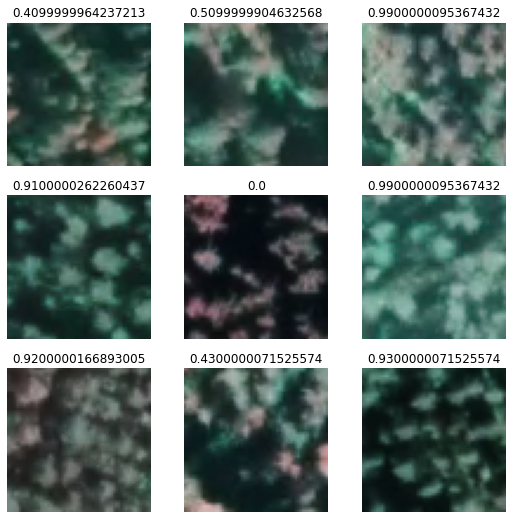

In [129]:
dls.show_batch()

In [130]:
f1_multi = F1ScoreMulti(average='micro')
pre_multi = PrecisionMulti(average='micro')
rec_multi = RecallMulti(average='micro')

In [184]:
model = cnn_learner(dls, densenet201, pretrained=False, 
                    
                    #metrics=[accuracy_multi, f1_multi, pre_multi, rec_multi], 
                    metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  
                    #metrics = [accuracy, Precision(average='macro'), Recall(average='macro'), F1Score(average='macro')], loss_func=LabelSmoothingCrossEntropy(),
                    y_range=(0,1),#900),
                    path='.', model_dir='models')

Little magic to ensure that results sum to 1

In [185]:
def norm_lr(x): return x / (x.sum(axis=-1)[:,None])
norm_lr = Lambda(norm_lr)

In [186]:
model.model = nn.Sequential(model.model, norm_lr)

In [187]:
model.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 31 x 31   
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 128 x 16 x 16  
Conv2d                                    8192       True      
BatchNorm2d                               256        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 16 x 16   
Conv2d                                    36864    

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0003311311302240938)

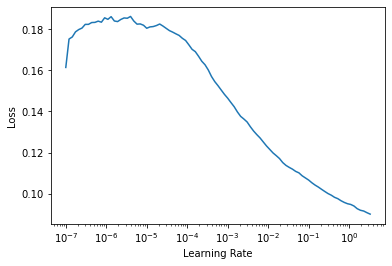

In [188]:
model.lr_find()

In [ ]:
model.fit_one_cycle(50, lr_max=1e-3)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.143102,0.144842,0.380581,114.199623,0.000074,0.022227,0.333424,-0.043138,00:04
1,0.119820,0.084349,0.290429,87.148079,0.000074,0.022227,0.235662,0.392525,00:04
2,0.103068,0.065533,0.255994,76.815262,0.000074,0.022227,0.195612,0.528037,00:04
3,0.091035,0.056550,0.237802,71.356583,0.000074,0.022228,0.175077,0.592732,00:04
4,0.082327,0.048837,0.220991,66.312164,0.000074,0.022227,0.156051,0.648278,00:04
5,0.075301,0.047890,0.218837,65.665771,0.000074,0.022227,0.145288,0.655102,00:04
6,0.069671,0.041513,0.203748,61.137932,0.000074,0.022227,0.140011,0.701026,00:04
7,0.065272,0.042459,0.206056,61.830513,0.000074,0.022227,0.143513,0.694213,00:04
8,0.061989,0.045153,0.212491,63.761532,0.000074,0.022227,0.154830,0.674815,00:04
9,0.060061,0.041762,0.204358,61.321102,0.000074,0.022228,0.134268,0.699231,00:04


## Classification interpretations

In [75]:
interp = ClassificationInterpretation.from_learner(model)

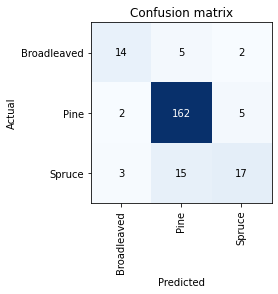

In [76]:
interp.plot_confusion_matrix()

In [77]:
interp.print_classification_report()

              precision    recall  f1-score   support

 Broadleaved       0.74      0.67      0.70        21
        Pine       0.89      0.96      0.92       169
      Spruce       0.71      0.49      0.58        35

    accuracy                           0.86       225
   macro avg       0.78      0.70      0.73       225
weighted avg       0.85      0.86      0.85       225



## Regression Interpretations

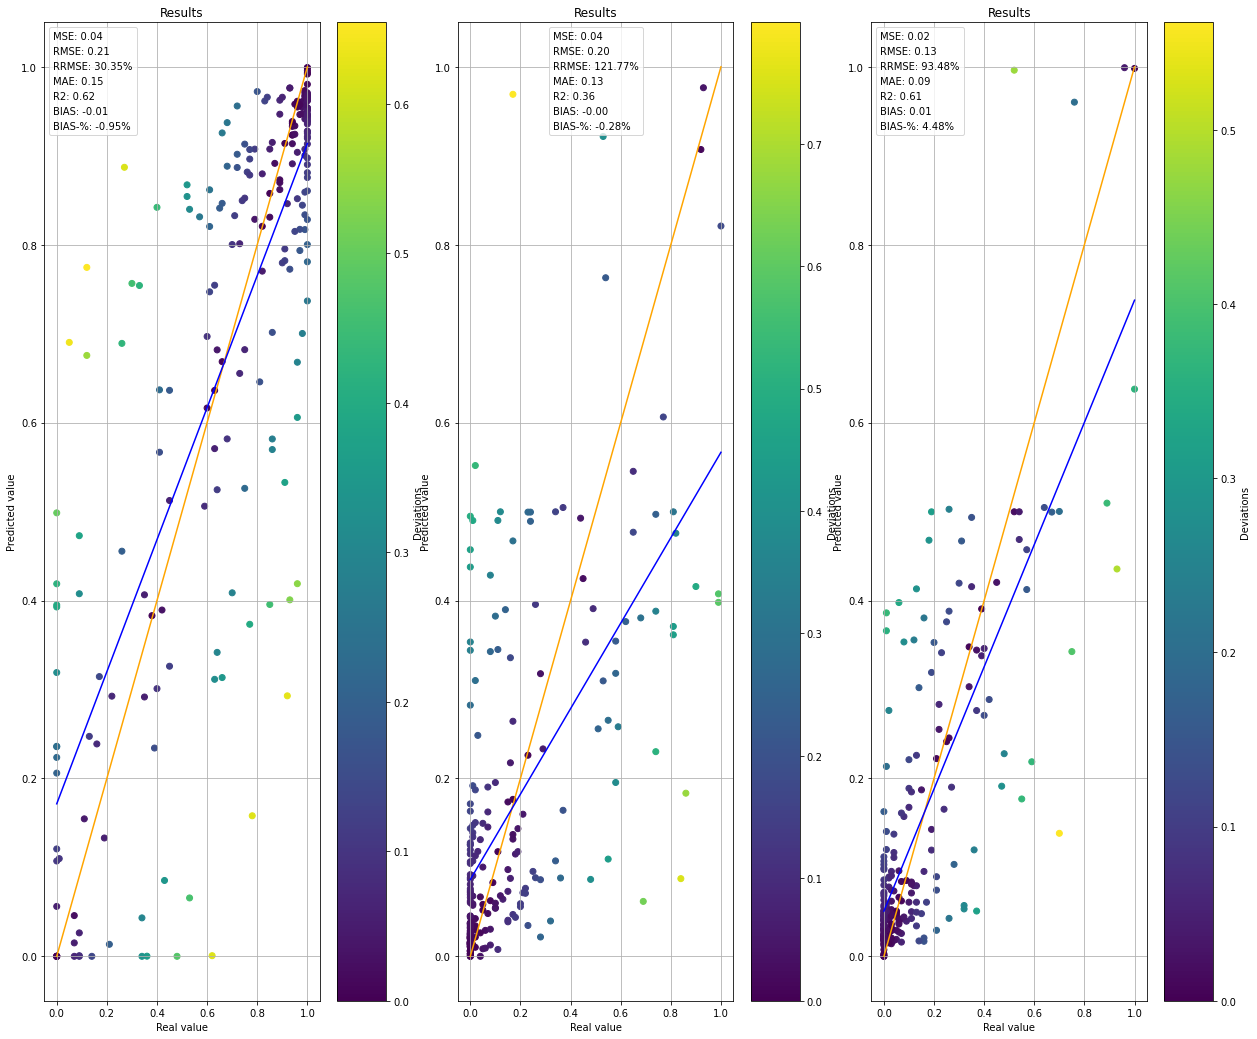

In [179]:
reg_interp = RegressionInterpretation.from_learner(model)
reg_interp.plot_results(log_y=False)
plt.show()

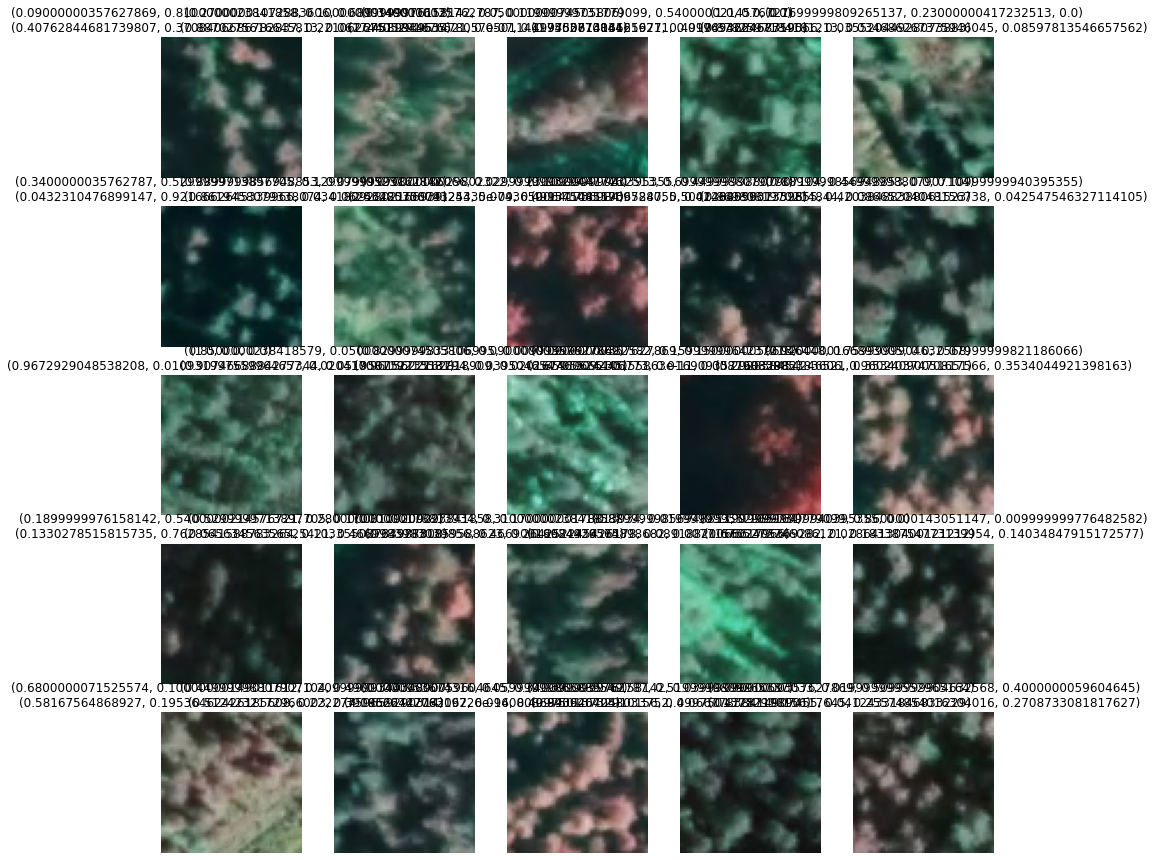

In [180]:
model.show_results(max_n=25)

In [181]:
preds, targs = model.get_preds()

In [183]:
preds.sum(axis=-1)

tensor([0.9990, 0.9992, 0.9996, 0.9989, 0.9991, 0.9987, 0.9988, 0.9987, 0.9988,
        0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9988, 0.9988, 0.9992, 0.9993,
        0.9992, 0.9990, 0.9992, 0.9996, 0.9990, 0.9988, 0.9987, 0.9987, 0.9989,
        0.9996, 0.9995, 0.9993, 0.9986, 0.9990, 0.9987, 0.9988, 0.9995, 0.9995,
        0.9989, 0.9990, 0.9990, 0.9988, 0.9995, 0.9995, 0.9995, 0.9992, 0.9990,
        0.9991, 0.9991, 0.9989, 0.9990, 0.9988, 0.9994, 0.9987, 0.9996, 0.9988,
        0.9991, 0.9991, 0.9988, 0.9987, 0.9993, 0.9996, 0.9990, 0.9988, 0.9990,
        0.9989, 0.9992, 0.9988, 0.9989, 0.9996, 0.9987, 0.9987, 0.9995, 0.9988,
        0.9993, 0.9997, 0.9990, 0.9988, 0.9990, 0.9990, 0.9992, 0.9994, 0.9988,
        0.9995, 0.9995, 0.9988, 0.9993, 0.9997, 0.9996, 0.9990, 0.9986, 0.9993,
        0.9989, 0.9990, 0.9987, 0.9986, 0.9995, 0.9995, 0.9990, 0.9992, 0.9994,
        0.9989, 0.9989, 0.9987, 0.9995, 0.9988, 0.9987, 0.9988, 0.9987, 0.9990,
        0.9987, 0.9987, 0.9997, 0.9995, 

## Multitarget

In [62]:
preds, targs = model.get_preds()

In [63]:
species = dls.vocab

Results for Broadleaf
              precision    recall  f1-score   support

      Absent       0.64      0.42      0.51        66
     Present       0.79      0.90      0.84       159

    accuracy                           0.76       225
   macro avg       0.71      0.66      0.68       225
weighted avg       0.74      0.76      0.74       225

Results for Pine
              precision    recall  f1-score   support

      Absent       0.36      0.24      0.29        17
     Present       0.94      0.97      0.95       208

    accuracy                           0.91       225
   macro avg       0.65      0.60      0.62       225
weighted avg       0.90      0.91      0.90       225

Results for Spruce
              precision    recall  f1-score   support

      Absent       0.67      0.67      0.67        86
     Present       0.80      0.80      0.80       139

    accuracy                           0.75       225
   macro avg       0.74      0.74      0.74       225
weighted avg    

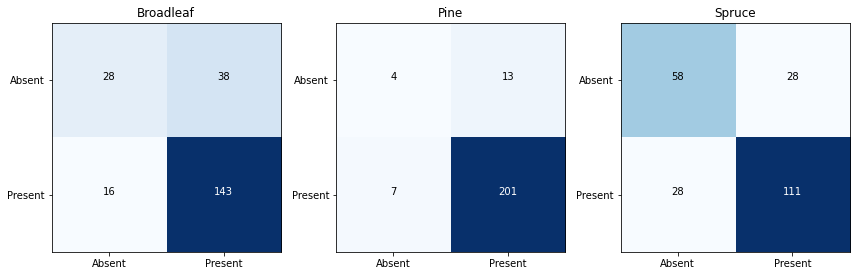

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product

fig, axs = plt.subplots(1,3, figsize=(12,5))

for i in range(len(species)):
    print(f'Results for {species[i]}')
    temp_preds = preds[:,i].numpy().copy()
    temp_preds[temp_preds < 0.5] = 0
    temp_preds[temp_preds >= 0.5] = 1
    print(classification_report(targs[:,i], temp_preds, target_names=['Absent', 'Present']))
    
    cm = confusion_matrix(targs[:,i], temp_preds)
    axs[i].imshow(cm, interpolation='nearest', cmap='Blues')
    axs[i].set_title(species[i])
    axs[i].set_xticks(np.arange(2))
    axs[i].set_yticks(np.arange(2))
    axs[i].set_xticklabels(['Absent', 'Present'])
    axs[i].set_yticklabels(['Absent', 'Present'])
    tresh = cm.max()/1.5
    for j, k in product(range(2), range(2)):
        axs[i].text(k, j, f'{cm[j,k]}',
                    horizontalalignment='center',
                    color='white' if cm[j,k] > tresh else 'black')
plt.tight_layout()

# Test set

In [63]:
test_dl = dls.test_dl(test_df, with_labels=True)

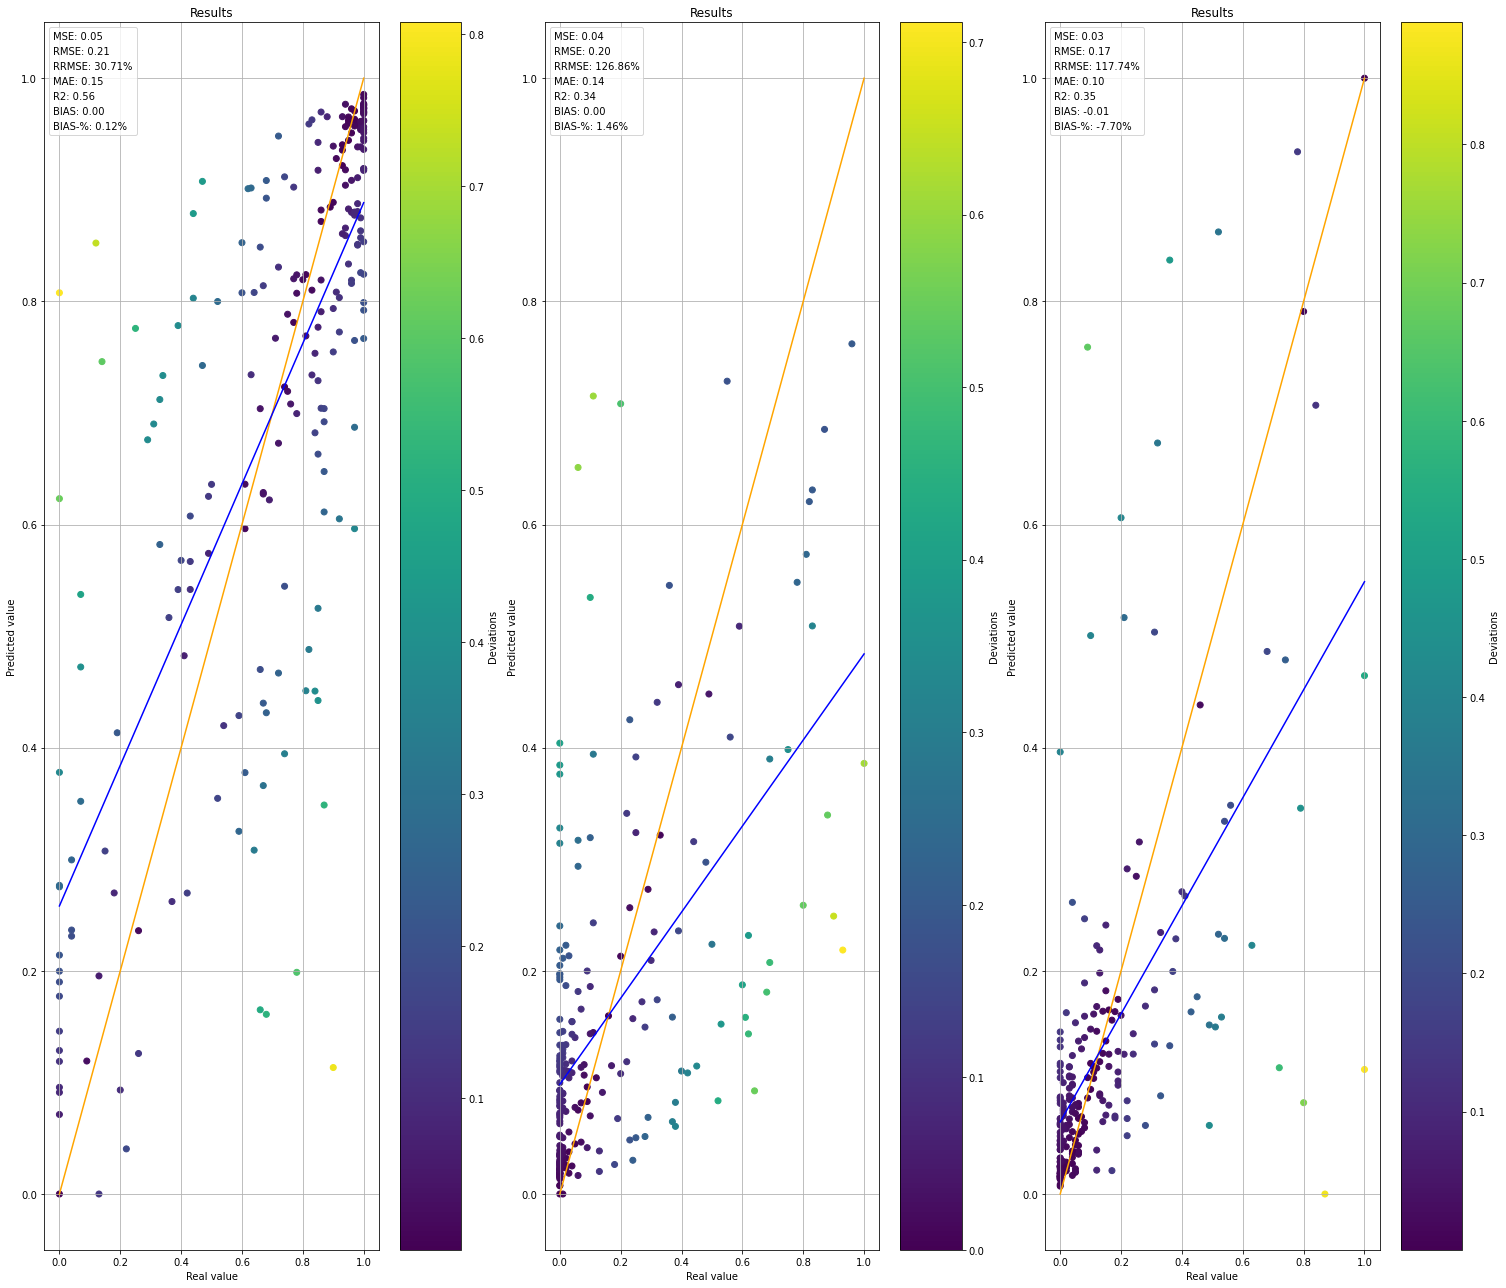

In [64]:
reg_interp = RegressionInterpretation.from_learner(model, dl=test_dl)
reg_interp.plot_results(log_y=False)
plt.tight_layout()
plt.show()


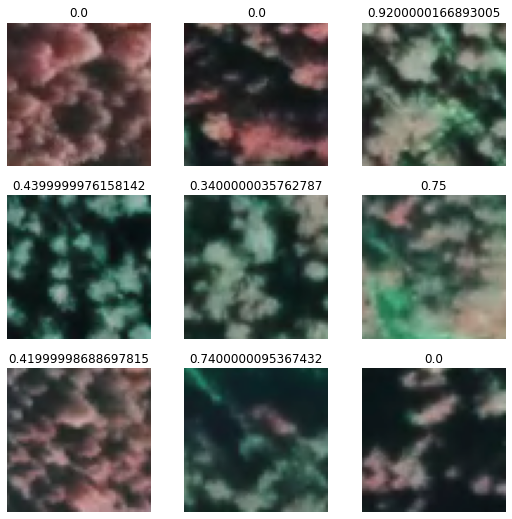

In [52]:
test_dl.show_batch()

## Multiclass

Results for Broadleaf
              precision    recall  f1-score   support

      Absent       0.62      0.47      0.54        53
     Present       0.85      0.91      0.88       172

    accuracy                           0.81       225
   macro avg       0.74      0.69      0.71       225
weighted avg       0.80      0.81      0.80       225

Results for Pine
              precision    recall  f1-score   support

      Absent       0.43      0.19      0.26        16
     Present       0.94      0.98      0.96       209

    accuracy                           0.92       225
   macro avg       0.68      0.58      0.61       225
weighted avg       0.90      0.92      0.91       225

Results for Spruce
              precision    recall  f1-score   support

      Absent       0.56      0.52      0.54        79
     Present       0.75      0.78      0.77       146

    accuracy                           0.69       225
   macro avg       0.66      0.65      0.65       225
weighted avg    

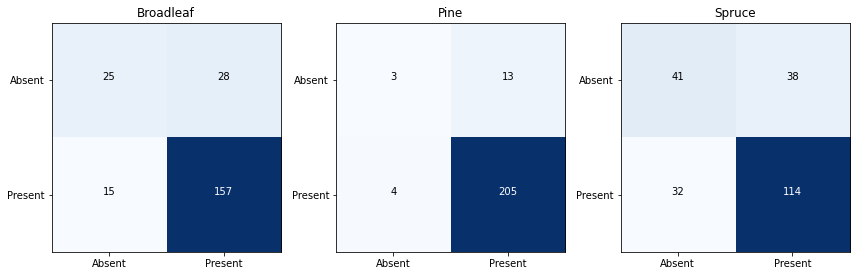

In [65]:
preds, targs = model.get_preds(dl=test_dl)
fig, axs = plt.subplots(1,3, figsize=(12,5))

for i in range(len(species)):
    print(f'Results for {species[i]}')
    temp_preds = preds[:,i].numpy().copy()
    temp_preds[temp_preds < 0.5] = 0
    temp_preds[temp_preds >= 0.5] = 1
    print(classification_report(targs[:,i], temp_preds, target_names=['Absent', 'Present']))
    
    cm = confusion_matrix(targs[:,i], temp_preds)
    axs[i].imshow(cm, interpolation='nearest', cmap='Blues')
    axs[i].set_title(species[i])
    axs[i].set_xticks(np.arange(2))
    axs[i].set_yticks(np.arange(2))
    axs[i].set_xticklabels(['Absent', 'Present'])
    axs[i].set_yticklabels(['Absent', 'Present'])
    tresh = cm.max()/1.5
    for j, k in product(range(2), range(2)):
        axs[i].text(k, j, f'{cm[j,k]}',
                    horizontalalignment='center',
                    color='white' if cm[j,k] > tresh else 'black')
plt.tight_layout()

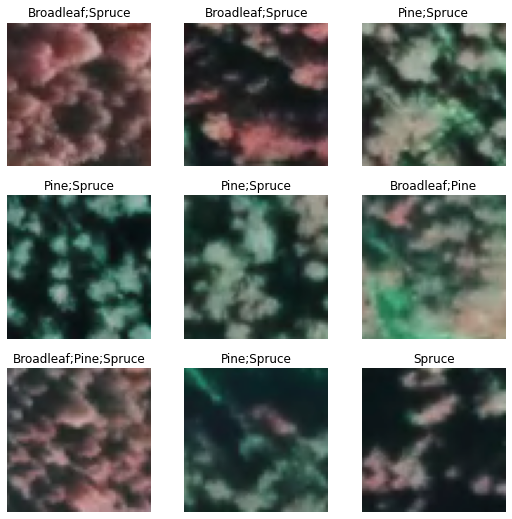

In [159]:
test_dl.show_batch()

# Gradcam

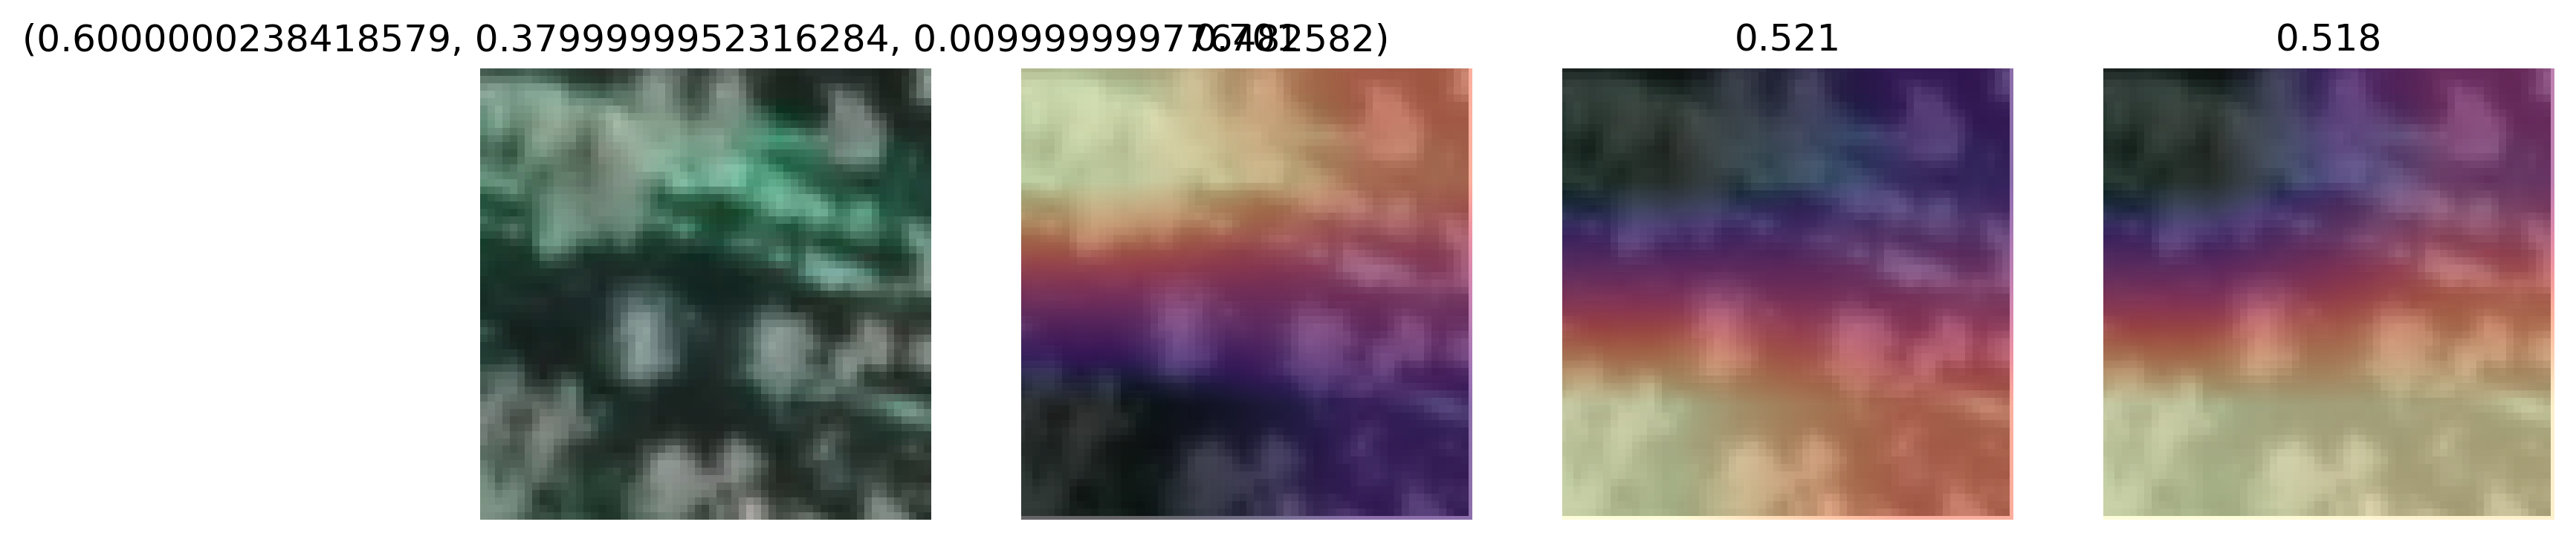

In [65]:
batch = test_dl.one_batch()
sigmoid = nn.Sigmoid()
targ_idx = np.random.randint(0, 64, 1)[0]
pred = sigmoid(model.model.eval()(batch[0]))[targ_idx]
pred_idx = [i for i in range_of(pred) if pred[i] > 0.5]
fig, ax = plt.subplots(1, 1+len(pred_idx), figsize=(4*len(pred_idx),4), dpi=300)
for i, ix in enumerate(pred_idx):
    plot_gradcam(model, batch[0][targ_idx], ax[i+1], target_class=ix,
                 im_cls=TensorImage)
    #ax[i+1].set_title(f'{species[ix]} {round(pred[ix].cpu().detach().item(),3)}')
    ax[i+1].set_title(f'{round(pred[ix].cpu().detach().item(),3)}')
test_dl.decode_batch(batch, max_n=64)[targ_idx][0].show(ax=ax[0], title=test_dl.decode_batch(batch, max_n=64)[targ_idx][1])
plt.show()